# 🇪🇬 Egypt Landmark Classifier — Colab Ready

This notebook is ready to run on Google Colab. It will:
1. Install required libs.
2. Upload `egypt_landmarks_dataset.zip` and extract it.
3. Prepare tf.data pipelines with augmentation + class weights.
4. Train EfficientNetB0 (transfer learning) and fine-tune.
5. Save model (`.h5` + SavedModel) and `label_map.json`.
6. Provide a simple inference UI to upload one image and get prediction + confidence.

Recommended: Runtime → Change runtime type → GPU. Then Run all cells.

In [1]:
!pip install tensorflow==2.19.0 tensorflow-text==2.19.0 tf-keras==2.19.0 tensorflow-decision-forests==1.12.0 --quiet


In [ ]:
%%capture
!pip install -q tensorflow==2.14.0 tensorflow_addons matplotlib seaborn scikit-learn

In [2]:
import os, zipfile, shutil, json
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import Counter

print('TF', tf.__version__)


TF 2.19.0


In [3]:
from google.colab import files
print('Upload your dataset ZIP (egypt_landmarks_dataset.zip)')
uploaded = files.upload()
zip_name = list(uploaded.keys())[0]
print('Uploaded:', zip_name)

data_root = '/content/data'
if os.path.exists(data_root):
    shutil.rmtree(data_root)
os.makedirs(data_root, exist_ok=True)
with zipfile.ZipFile(zip_name, 'r') as z:
    z.extractall(data_root)

# detect data dir
subfolders = [f for f in os.listdir(data_root) if os.path.isdir(os.path.join(data_root,f))]
if len(subfolders)==1:
    cand = os.path.join(data_root, subfolders[0])
    if any(os.path.isdir(os.path.join(cand,d)) for d in os.listdir(cand)):
        data_dir = cand
    else:
        data_dir = data_root
else:
    data_dir = data_root
print('Using data dir:', data_dir)
classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir,d))])
print('Found classes:', len(classes))
for c in classes:
    cnt = len(list(Path(os.path.join(data_dir,c)).rglob('*.*')))
    print(f' - {c}: {cnt}')


Upload your dataset ZIP (egypt_landmarks_dataset.zip)


Saving egypt_landmarks_dataset.zip to egypt_landmarks_dataset.zip
Uploaded: egypt_landmarks_dataset.zip
Using data dir: /content/data/egypt_landmarks_dataset
Found classes: 30
 - Aisha Fahmy Palace: 29
 - Al-Azhar Mosque: 37
 - Amr Ibn Al-Aas Mosque: 30
 - Bab_Zuweila: 28
 - Baron Empain Palace: 55
 - Bent pyramid for senefru: 433
 - Cairo Opera House: 35
 - Cairo University Clock: 21
 - Cairo_Tower: 66
 - Egypt_Renaissance_Statue: 33
 - Egyptian_Museum: 16
 - Grand_Egyptian_Museum: 28
 - Hanging_Church: 47
 - Ibrahim Pasha Statue: 64
 - Khafre Pyramid: 444
 - Muhammad Ali Mosque: 41
 - October_War_Panorama: 18
 - Pyramid of Khufu: 24
 - Pyramid_of_Djoser: 173
 - Qasr_El_Nil_Lion_Statue: 78
 - Saad Zaghloul Statue: 35
 - Senusret_I_Obelisk: 57
 - Simon Bolívar Statue: 31
 - Solar_Boat_Museum: 56
 - Sultan Hassan Mosque: 34
 - Tal'at Harb Statue: 52
 - The Virgin Mary’s tree: 45
 - The_Sphinx_Statue_Inside_the_Museum: 45
 - menkaure pyramid: 173
 - sphinx: 410


In [4]:
# Prepare lists
from sklearn.model_selection import train_test_split
file_paths=[]
labels=[]
for c in classes:
    for p in Path(os.path.join(data_dir,c)).rglob('*.*'):
        file_paths.append(str(p))
        labels.append(c)
print('Total images:', len(file_paths))
train_paths, test_paths, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.15, stratify=labels, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.17647, stratify=train_labels, random_state=42)
print('Splits ->', len(train_paths), len(val_paths), len(test_paths))


Total images: 2638
Splits -> 1846 396 396


In [5]:
IMG_SIZE = 300
GPU = len(tf.config.list_physical_devices('GPU'))>0
BATCH_SIZE = 32 if GPU else 8
AUTOTUNE = tf.data.AUTOTUNE

label_to_index = {c:i for i,c in enumerate(classes)}
index_to_label = {v:k for k,v in label_to_index.items()}

def decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img, label

def paths_labels_to_ds(paths, labels_list, shuffle=False):
    labels_idx = [label_to_index[l] for l in labels_list]
    ds = tf.data.Dataset.from_tensor_slices((paths, labels_idx))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), reshuffle_each_iteration=True)
    ds = ds.map(lambda p,l: decode_and_resize(p,l), num_parallel_calls=AUTOTUNE)
    return ds

train_ds = paths_labels_to_ds(train_paths, train_labels, shuffle=True)
val_ds = paths_labels_to_ds(val_paths, val_labels)
test_ds = paths_labels_to_ds(test_paths, test_labels)

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.12),
    layers.RandomZoom(0.12),
    layers.RandomContrast(0.12),
])

train_ds = train_ds.map(lambda x,y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
print('BATCH_SIZE =', BATCH_SIZE)


BATCH_SIZE = 32


In [6]:
from collections import Counter
counts = Counter(train_labels)
total = sum(counts.values())
class_weights = {}
for lbl, cnt in counts.items():
    class_weights[label_to_index[lbl]] = (1.0 * total) / (len(classes) * cnt)
print('Class weights ready')


Class weights ready


In [7]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), weights='imagenet', pooling='avg')
base_model.trainable = False
inputs = keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs*255.0)
x = base_model(x, training=False)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(len(classes), activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │        38,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,088,001 (15.59 MB)

 Trainable params: 38,430 (150.12 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
checkpoint = '/content/landmark_best.h5'
callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_accuracy', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]


In [9]:
import os
from pathlib import Path
from PIL import Image

# افترض أن 'data_dir' لا يزال معرفًا من الـ Cell الثالث لديك
print(f"Starting file integrity check in: {data_dir}...")
bad_files = []
total_files = 0

for root, _, files in os.walk(data_dir):
    for filename in files:
        total_files += 1
        filepath = os.path.join(root, filename)

        # تجاهل ملفات النظام الشائعة أولاً
        if filename.startswith('.'):
            continue

        try:
            # محاولة فتح الملف كصورة
            img = Image.open(filepath)
            img.verify() # تحقق من سلامة الملف
            img.close()
        except Exception as e:
            # إذا فشلت PIL في الفتح أو التحقق، يتم تسجيل الملف
            bad_files.append(filepath)
            print(f"ERROR: Failed to process file: {filepath} ({e})")

print(f"\n--- Check Complete ---")
print(f"Total files checked: {total_files}")

if bad_files:
    print(f"Found {len(bad_files)} bad files. Please remove them before retraining.")
    print("List of bad files:")
    for f in bad_files:
        print(f)
else:
    print("All files passed the basic image check. The error might be due to a specific TensorFlow issue with a valid file.")

Starting file integrity check in: /content/data/egypt_landmarks_dataset...

--- Check Complete ---
Total files checked: 2638
All files passed the basic image check. The error might be due to a specific TensorFlow issue with a valid file.


In [10]:
E1 = 8
hist1 = model.fit(train_ds, validation_data=val_ds, epochs=E1, class_weight=class_weights, callbacks=callbacks)


Epoch 1/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.0784 - loss: 3.3647
Epoch 1: val_accuracy improved from -inf to 0.33586, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.0789 - loss: 3.3662 - val_accuracy: 0.3359 - val_loss: 2.9434 - learning_rate: 1.0000e-04
Epoch 2/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.2026 - loss: 3.3040
Epoch 2: val_accuracy improved from 0.33586 to 0.46717, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 642ms/step - accuracy: 0.2030 - loss: 3.3024 - val_accuracy: 0.4672 - val_loss: 2.6293 - learning_rate: 1.0000e-04
Epoch 3/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.3206 - loss: 3.1100
Epoch 3: val_accuracy improved from 0.46717 to 0.51768, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 635ms/step - accuracy: 0.3209 - loss: 3.1080 - val_accuracy: 0.5177 - val_loss: 2.3784 - learning_rate: 1.0000e-04
Epoch 4/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.3921 - loss: 2.8139
Epoch 4: val_accuracy improved from 0.51768 to 0.57576, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 631ms/step - accuracy: 0.3922 - loss: 2.8144 - val_accuracy: 0.5758 - val_loss: 2.1652 - learning_rate: 1.0000e-04
Epoch 5/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.4611 - loss: 2.6916
Epoch 5: val_accuracy improved from 0.57576 to 0.61869, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 642ms/step - accuracy: 0.4613 - loss: 2.6917 - val_accuracy: 0.6187 - val_loss: 1.9950 - learning_rate: 1.0000e-04
Epoch 6/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.5380 - loss: 2.5322
Epoch 6: val_accuracy improved from 0.61869 to 0.67424, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 637ms/step - accuracy: 0.5378 - loss: 2.5326 - val_accuracy: 0.6742 - val_loss: 1.8442 - learning_rate: 1.0000e-04
Epoch 7/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.5574 - loss: 2.4483
Epoch 7: val_accuracy improved from 0.67424 to 0.69444, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 636ms/step - accuracy: 0.5577 - loss: 2.4477 - val_accuracy: 0.6944 - val_loss: 1.7236 - learning_rate: 1.0000e-04
Epoch 8/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.6171 - loss: 2.2284
Epoch 8: val_accuracy improved from 0.69444 to 0.72222, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 632ms/step - accuracy: 0.6171 - loss: 2.2297 - val_accuracy: 0.7222 - val_loss: 1.6190 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 8.


In [11]:
base_model.trainable = True
fine_tune_at = int(len(base_model.layers)*0.6)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
model.compile(optimizer=keras.optimizers.Adam(5e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
E2 = 12
hist2 = model.fit(train_ds, validation_data=val_ds, epochs=E2, class_weight=class_weights, callbacks=callbacks)


Epoch 1/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.2725 - loss: 2.7821
Epoch 1: val_accuracy improved from 0.72222 to 0.78283, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.2737 - loss: 2.7812 - val_accuracy: 0.7828 - val_loss: 1.5308 - learning_rate: 5.0000e-05
Epoch 2/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.6001 - loss: 2.3200
Epoch 2: val_accuracy improved from 0.78283 to 0.79798, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 39s 672ms/step - accuracy: 0.6004 - loss: 2.3171 - val_accuracy: 0.7980 - val_loss: 1.3549 - learning_rate: 5.0000e-05
Epoch 3/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.7430 - loss: 1.7862
Epoch 3: val_accuracy improved from 0.79798 to 0.82323, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 700ms/step - accuracy: 0.7430 - loss: 1.7840 - val_accuracy: 0.8232 - val_loss: 1.1609 - learning_rate: 5.0000e-05
Epoch 4/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.7857 - loss: 1.3410
Epoch 4: val_accuracy improved from 0.82323 to 0.84848, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 43s 728ms/step - accuracy: 0.7859 - loss: 1.3397 - val_accuracy: 0.8485 - val_loss: 1.0047 - learning_rate: 5.0000e-05
Epoch 5/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.8397 - loss: 1.0110
Epoch 5: val_accuracy improved from 0.84848 to 0.86111, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 689ms/step - accuracy: 0.8396 - loss: 1.0103 - val_accuracy: 0.8611 - val_loss: 0.8901 - learning_rate: 5.0000e-05
Epoch 6/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.8637 - loss: 0.8715
Epoch 6: val_accuracy improved from 0.86111 to 0.86364, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 684ms/step - accuracy: 0.8636 - loss: 0.8700 - val_accuracy: 0.8636 - val_loss: 0.7699 - learning_rate: 5.0000e-05
Epoch 7/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.8801 - loss: 0.6838
Epoch 7: val_accuracy improved from 0.86364 to 0.88131, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 39s 669ms/step - accuracy: 0.8801 - loss: 0.6833 - val_accuracy: 0.8813 - val_loss: 0.6704 - learning_rate: 5.0000e-05
Epoch 8/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.8954 - loss: 0.5560
Epoch 8: val_accuracy improved from 0.88131 to 0.89141, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 659ms/step - accuracy: 0.8954 - loss: 0.5560 - val_accuracy: 0.8914 - val_loss: 0.6052 - learning_rate: 5.0000e-05
Epoch 9/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9050 - loss: 0.4637
Epoch 9: val_accuracy improved from 0.89141 to 0.90657, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 666ms/step - accuracy: 0.9049 - loss: 0.4644 - val_accuracy: 0.9066 - val_loss: 0.5359 - learning_rate: 5.0000e-05
Epoch 10/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9149 - loss: 0.4002
Epoch 10: val_accuracy improved from 0.90657 to 0.91667, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 39s 664ms/step - accuracy: 0.9148 - loss: 0.4002 - val_accuracy: 0.9167 - val_loss: 0.4701 - learning_rate: 5.0000e-05
Epoch 11/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.9214 - loss: 0.3468
Epoch 11: val_accuracy improved from 0.91667 to 0.92929, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 39s 664ms/step - accuracy: 0.9213 - loss: 0.3471 - val_accuracy: 0.9293 - val_loss: 0.4214 - learning_rate: 5.0000e-05
Epoch 12/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9376 - loss: 0.2765
Epoch 12: val_accuracy did not improve from 0.92929
58/58 ━━━━━━━━━━━━━━━━━━━━ 38s 658ms/step - accuracy: 0.9376 - loss: 0.2766 - val_accuracy: 0.9293 - val_loss: 0.3806 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 11.


In [12]:
test_loss, test_acc = model.evaluate(test_ds)
print('Test acc:', test_acc)
# حفظ النموذج بصيغة Keras الحديثة (موصى بها)
model.save('/content/landmark_classifier.keras')

# حفظ النموذج بصيغة SavedModel (لو حابب تستخدمه في تطبيق أو TFLite)
model.export('/content/landmark_classifier_saved')

# حفظ بصيغة HDF5 (اختياري لو عايز تكون متوافق مع إصدارات أقدم)
model.save('/content/landmark_classifier.h5')


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9080 - loss: 0.4419
Test acc: 0.9191918969154358
Saved artifact at '/content/landmark_classifier_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name='keras_tensor_244')
Output Type:
  TensorSpec(shape=(None, 30), dtype=tf.float32, name=None)
Captures:
  136391922793360: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136391922791824: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136392024064272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136392024064080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136392024064848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136392024065616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136392024066192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136392024064464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1363920240

In [14]:
import os, json

train_dir = '/content/data/egypt_landmarks_dataset'  # غيّر المسار حسب اللي عندك
class_names = sorted(os.listdir(train_dir))

# احفظها في JSON
with open('/content/label_map.json','w', encoding='utf-8') as f:
    json.dump(class_names, f, ensure_ascii=False, indent=2)

print("✅ label_map.json saved successfully!")

✅ label_map.json saved successfully!


In [ ]:
import json
import os

# المسار اللي استخدمته لتوليد train_ds
train_dir = '/content/data/egypt_landmarks_dataset'

# استخراج أسماء الفئات من المجلدات
class_names = sorted(os.listdir(train_dir))

# إنشاء الخريطة
label_map = {i: name for i, name in enumerate(class_names)}

# حفظها كـ JSON
with open('/content/label_map.json', 'w', encoding='utf-8') as f:
    json.dump(label_map, f, ensure_ascii=False, indent=2)

print("✅ label_map.json saved successfully with", len(label_map), "classes!")


✅ label_map.json saved successfully with 30 classes!


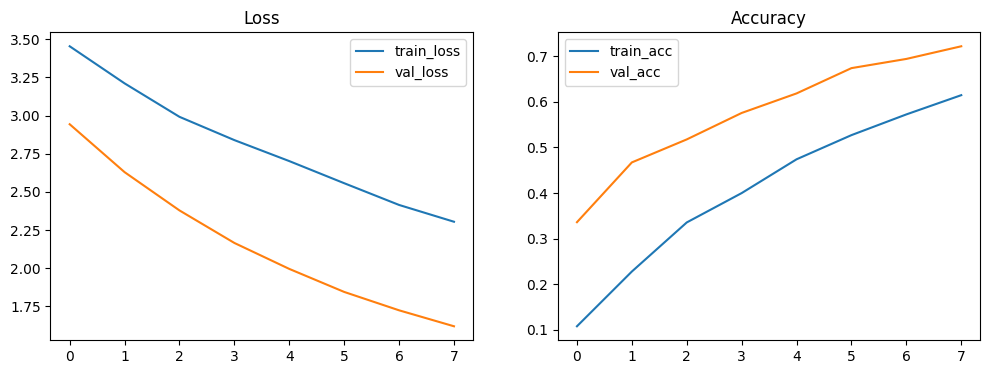

In [15]:
import matplotlib.pyplot as plt
def plot_hist(h1,h2=None):
  plt.figure(figsize=(12,4))
  plt.subplot(1,2,1)
  plt.plot(h1.history['loss'], label='train_loss')
  plt.plot(h1.history['val_loss'], label='val_loss')
  plt.legend(); plt.title('Loss')
  plt.subplot(1,2,2)
  plt.plot(h1.history['accuracy'], label='train_acc')
  plt.plot(h1.history['val_accuracy'], label='val_acc')
  plt.legend(); plt.title('Accuracy')
  plt.show()
plot_hist(hist1, hist2)


In [35]:
from google.colab import files
from PIL import Image
import numpy as np

print("Upload an image to predict:")
upl = files.upload()


Upload an image to predict:


In [36]:
# تحميل الصورة واختبار النموذج عليها
for fn in upl.keys():
    img = Image.open(fn).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    x = np.expand_dims(np.array(img) / 255.0, axis=0)

    preds = model.predict(x)
    predicted_class = class_names[np.argmax(preds)]
    confidence = np.max(preds)

    print(f"🏛️ Predicted landmark: {predicted_class} ({confidence:.2%} confidence)")


In [37]:
# Download artifacts
from google.colab import files as gfiles
gfiles.download('/content/landmark_classifier.h5')
gfiles.download('/content/label_map.json')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
from google.colab import files
import shutil
import os

# اسم ملف الـ ZIP النهائي
zip_filename = "landmark_project_files.zip"

# 1️⃣ اعمل ملف ZIP للمجلد بتاع الـ SavedModel
saved_model_dir = "landmark_classifier_saved"
if os.path.exists(saved_model_dir):
    shutil.make_archive("landmark_classifier_saved", 'zip', saved_model_dir)
    print("✅ SavedModel folder zipped!")

# 2️⃣ اعمل ملف ZIP لكل المشروع
files_to_zip = [
    "label_map.json",
    "landmark_best.h5",
    "landmark_classifier.h5",
    "landmark_classifier.keras",
    "landmark_classifier_saved.zip"
]

# لو في ملفات ناقصة، تجاهلها من غير ما يعمل Error
files_to_zip = [f for f in files_to_zip if os.path.exists(f)]

# 3️⃣ استخدم أمر zip بشكل صحيح
!zip -r {zip_filename} {' '.join(files_to_zip)}

# 4️⃣ نزّل الملف المضغوط
files.download(zip_filename)


✅ SavedModel folder zipped!
  adding: label_map.json (deflated 47%)
  adding: landmark_best.h5 (deflated 9%)
  adding: landmark_classifier.h5 (deflated 9%)
  adding: landmark_classifier.keras (deflated 10%)
  adding: landmark_classifier_saved.zip (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>